In [1]:
using Gen
using Plots

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


## A generative model for linear regression

Meh.

In [3]:
@gen function model(args::Vector{Float64})
    slope = @trace(normal(-1, exp(0.5)), :slope)
    intercept = @trace(normal(1, exp(2.0)), :intercept)
    for (i, arg) in enumerate(args)
        {:data=>i} ~ normal(slope * arg + intercept, 1)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##model#293", Bool[0], false)

Observe some `data` 

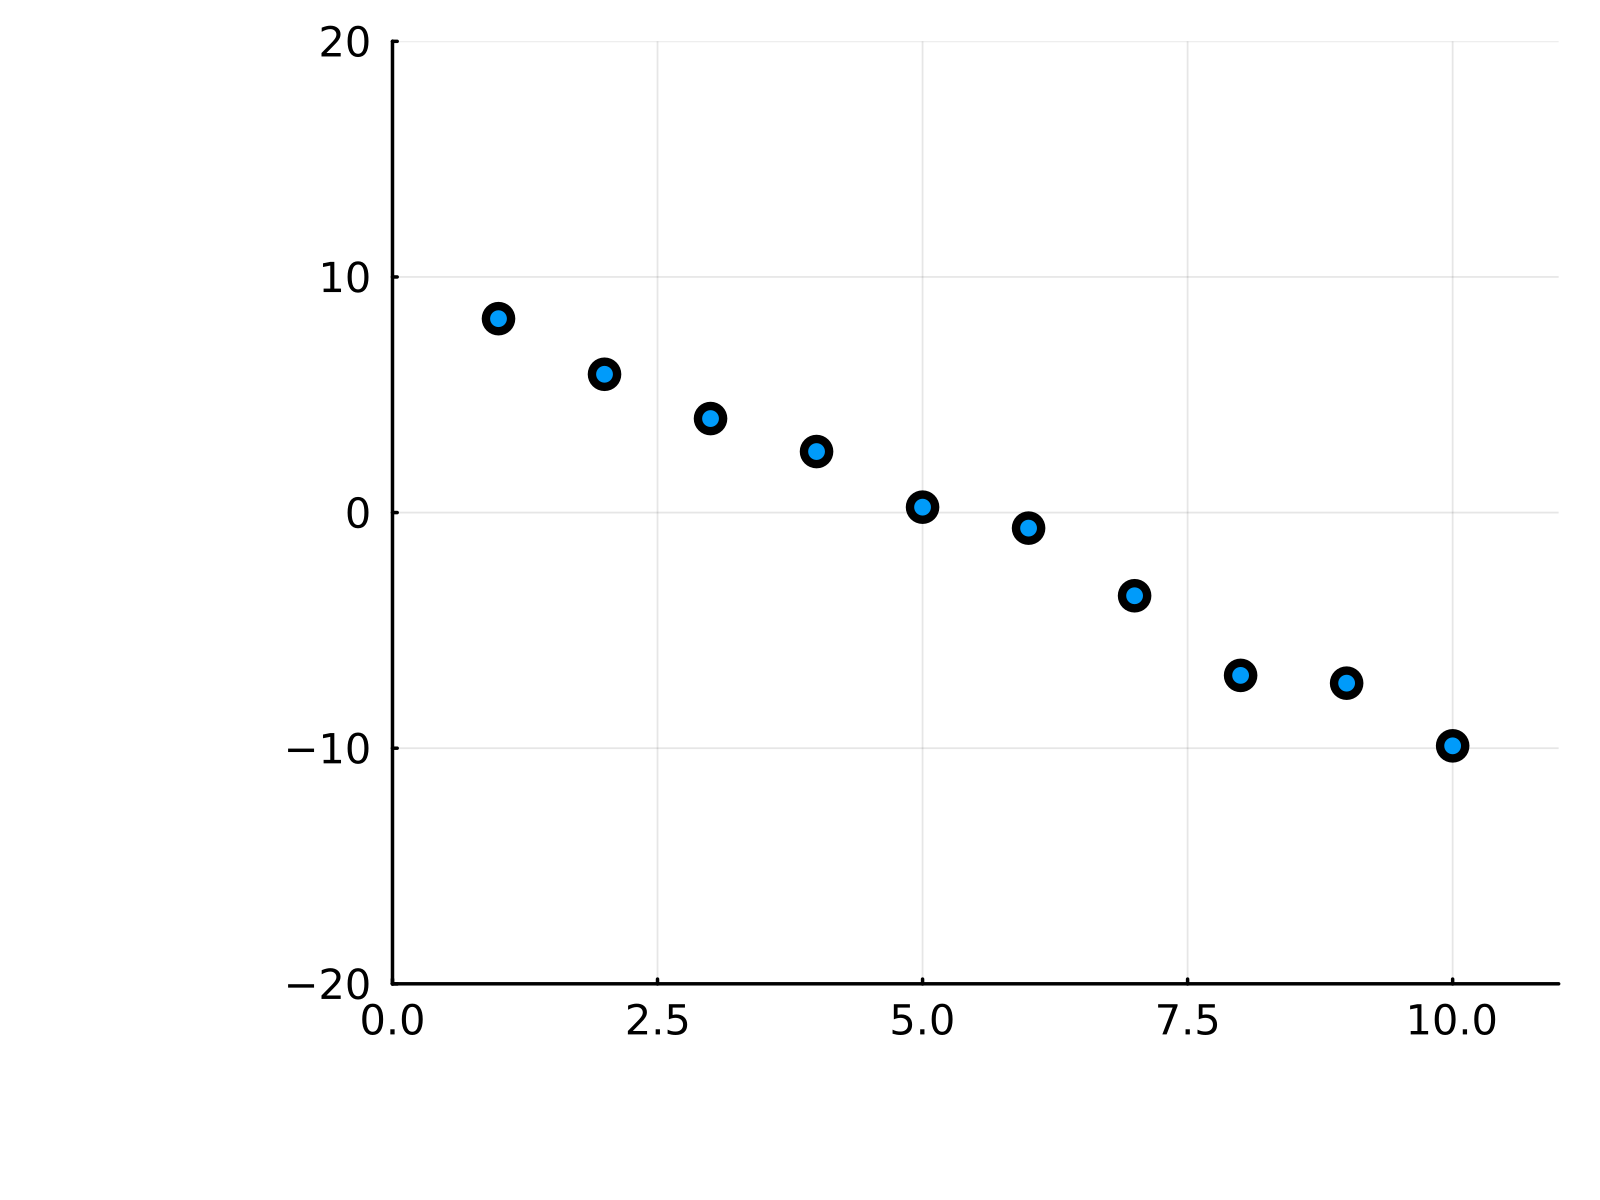

In [4]:
args = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
data = [8.23, 5.87, 3.99, 2.59, 0.23, -0.66, -3.53, -6.91, -7.24, -9.90]

observations = choicemap()
for (i, d) in enumerate(data)
    observations[:data=>i] = d
end

scatter(args, data, xlims=[0, 11], ylims=[-20, 20], label=nothing, thickness_scaling=3.5, size=(1600, 1200))

## MAP optimization

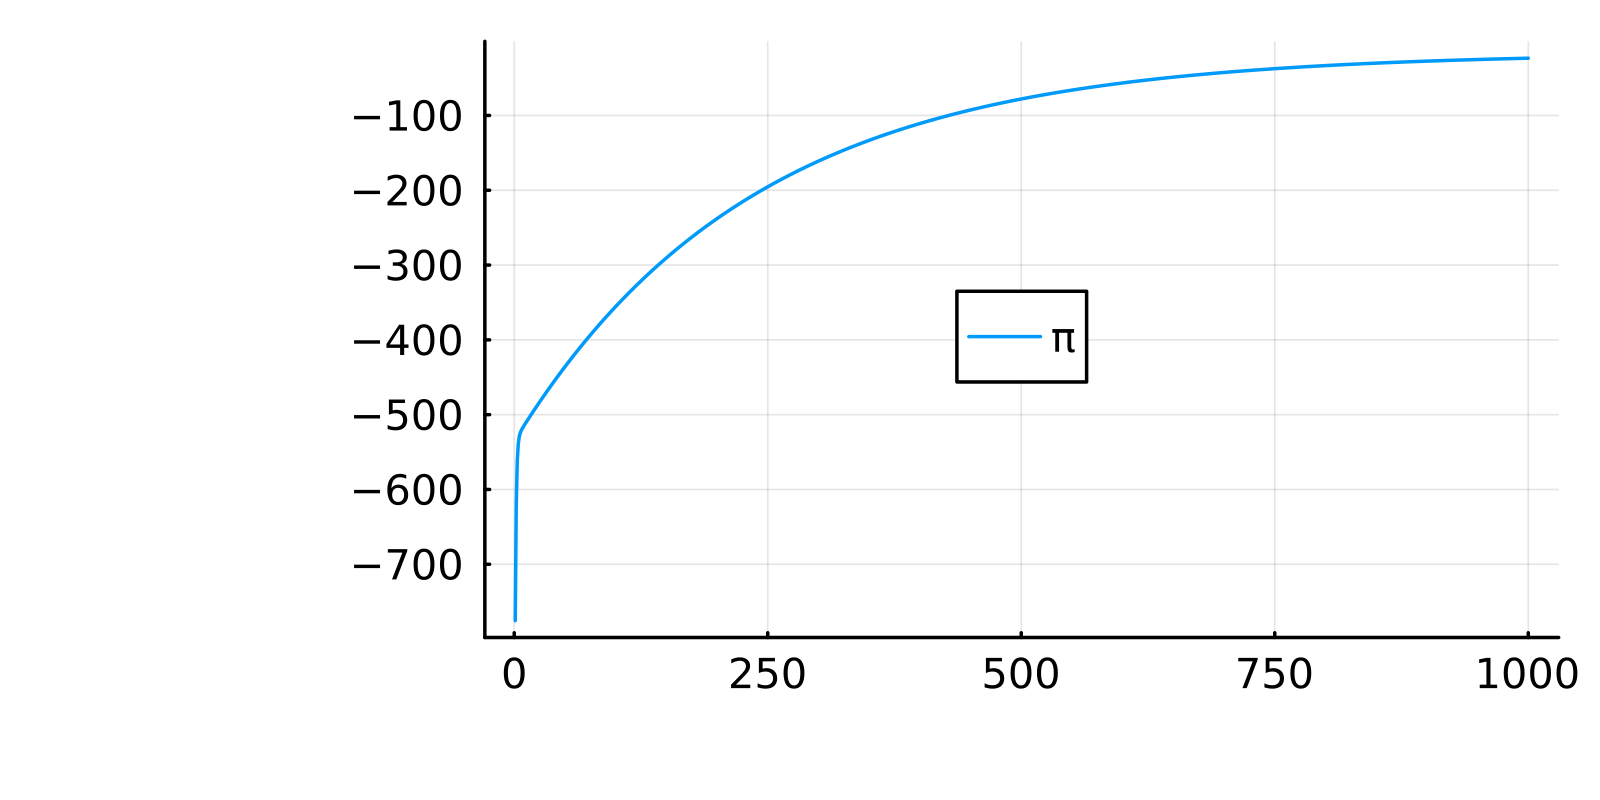

In [5]:
# initialize a random starting point
tr, _ = Gen.generate(model, (args,), observations)
# an array to collect our log proto-posterior scores
πs = []
for i=1:1000
    # take a single gradient descent step with step size 1e-3 
    tr = map_optimize(tr, select(:slope, :intercept), max_step_size=1e-3, min_step_size=1e-3)
    # push the log score into array
    push!(πs, get_score(tr))
end
# visualize the log score 
plot(πs, labels="π", thickness_scaling=3.5, size=(1600, 800), legend=:inside)

In [6]:
get_choices(tr)

│
├── :intercept : 7.513750671159333
│
├── :slope : -1.602336108767023
│
└── :data
    │
    ├── 5 : 0.23
    │
    ├── 4 : 2.59
    │
    ├── 6 : -0.66
    │
    ├── 7 : -3.53
    │
    ├── 2 : 5.87
    │
    ├── 10 : -9.9
    │
    ├── 9 : -7.24
    │
    ├── 8 : -6.91
    │
    ├── 3 : 3.99
    │
    └── 1 : 8.23


In [7]:
function visualize_trace(trs, args, obs, title)
    if typeof(trs)==Vector{Any}
        tr = trs[1]
        N = length(trs)
    else
        tr = trs
        N = 1
    end
    data = [obs[:data=>i] for i in 1:length(args)]
    plt = scatter(args, data, xlims=[0, 11], ylims=[-20, 20], label=nothing, thickness_scaling=3.5, size=(1600, 1200))
    for i = 1:N
        if i == 1
            tr = tr
        else
            tr = trs[i]
        end
        inferred_line(x) = tr[:slope] * x + tr[:intercept]
        left_x = 0
        left_y  = inferred_line(left_x)
        right_x = 11
        right_y = inferred_line(right_x)
        plt = plot!([left_x, right_x], [left_y, right_y], color="black", label=nothing) 
    end
    plt
end

visualize_trace (generic function with 1 method)

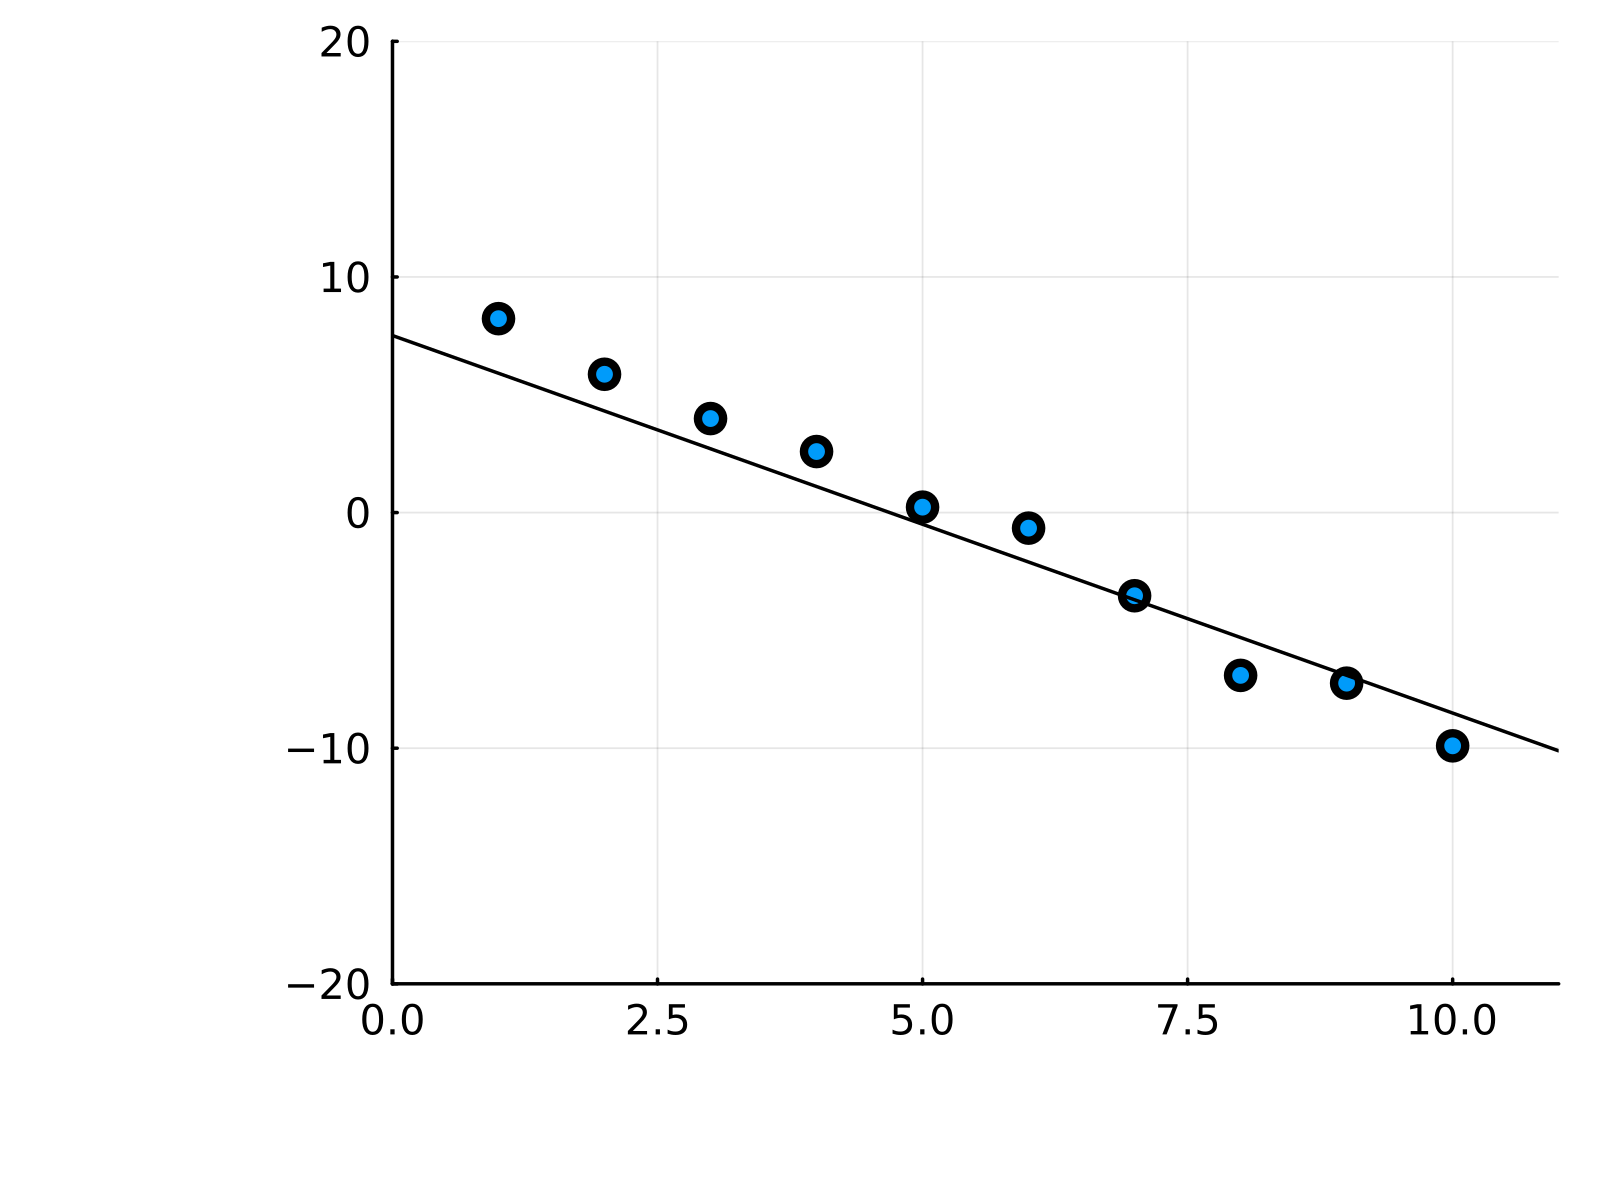

In [9]:
visualize_trace(tr, args, observations, "MAP")

## Variational inference

Our variational distribution to approximate the posterior `approx`

In [10]:
@gen function approx(args::Vector{Float64})
    # parametrize the marginal of :slope
    @param slope_mu::Float64
    @param slope_log_std::Float64
    # parametrize the marginal of :intercept
    @param intercept_mu::Float64
    @param intercept_log_std::Float64
    # make the relevant random choices with these variational distributions
    slope = @trace(normal(slope_mu, exp(slope_log_std)), :slope)
    intercept = @trace(normal(intercept_mu, exp(intercept_log_std)), :intercept)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##approx#297", Bool[0], false)

Initialize the trainable parameters and then perform black box variational inference ... 

Notice the use of 100 times more resources than the MAP optimization procedure. For each step, we draw 100 samples from `approx` to estimate the gradient of the variational distribution relative to log score.

Play around with these choices. 

In [13]:
function variational_inference(args, observations)
    # initialize variational params
    init_param!(approx, :slope_mu, 0.)
    init_param!(approx, :slope_log_std, 0.)
    init_param!(approx, :intercept_mu, 0.)
    init_param!(approx, :intercept_log_std, 0.)
    # get an optimizer
    update = ParamUpdate(GradientDescent(1e-3, 100000), approx)
    # variational inference!
    (elbo_estimate, traces, elbo_history) = 
        black_box_vi!(model, (args,), observations, approx, (args,), update;
        iters=1000, samples_per_iter=100, verbose=true)
    return elbo_history
end

variational_inference (generic function with 1 method)

iter 1; est objective: -355.4515540306747
iter 2; est objective: -205.22583266156894
iter 3; est objective: -221.80057207631987
iter 4; est objective: -171.80125729133758
iter 5; est objective: -179.01813927689125
iter 6; est objective: -181.36094967673313
iter 7; est objective: -153.09552510065888
iter 8; est objective: -146.0074535528873
iter 9; est objective: -149.83196933712537
iter 10; est objective: -141.21524137353063
iter 11; est objective: -148.66538744521452
iter 12; est objective: -149.56719042061493
iter 13; est objective: -146.0458065306815
iter 14; est objective: -139.67551767991048
iter 15; est objective: -138.96506960650947
iter 16; est objective: -136.66186795978854
iter 17; est objective: -137.23091538521712
iter 18; est objective: -129.93777407990683
iter 19; est objective: -135.78838667785814
iter 20; est objective: -130.56942965520093
iter 21; est objective: -127.28298408725458
iter 22; est objective: -127.78322800828668
iter 23; est objective: -125.67648658920184


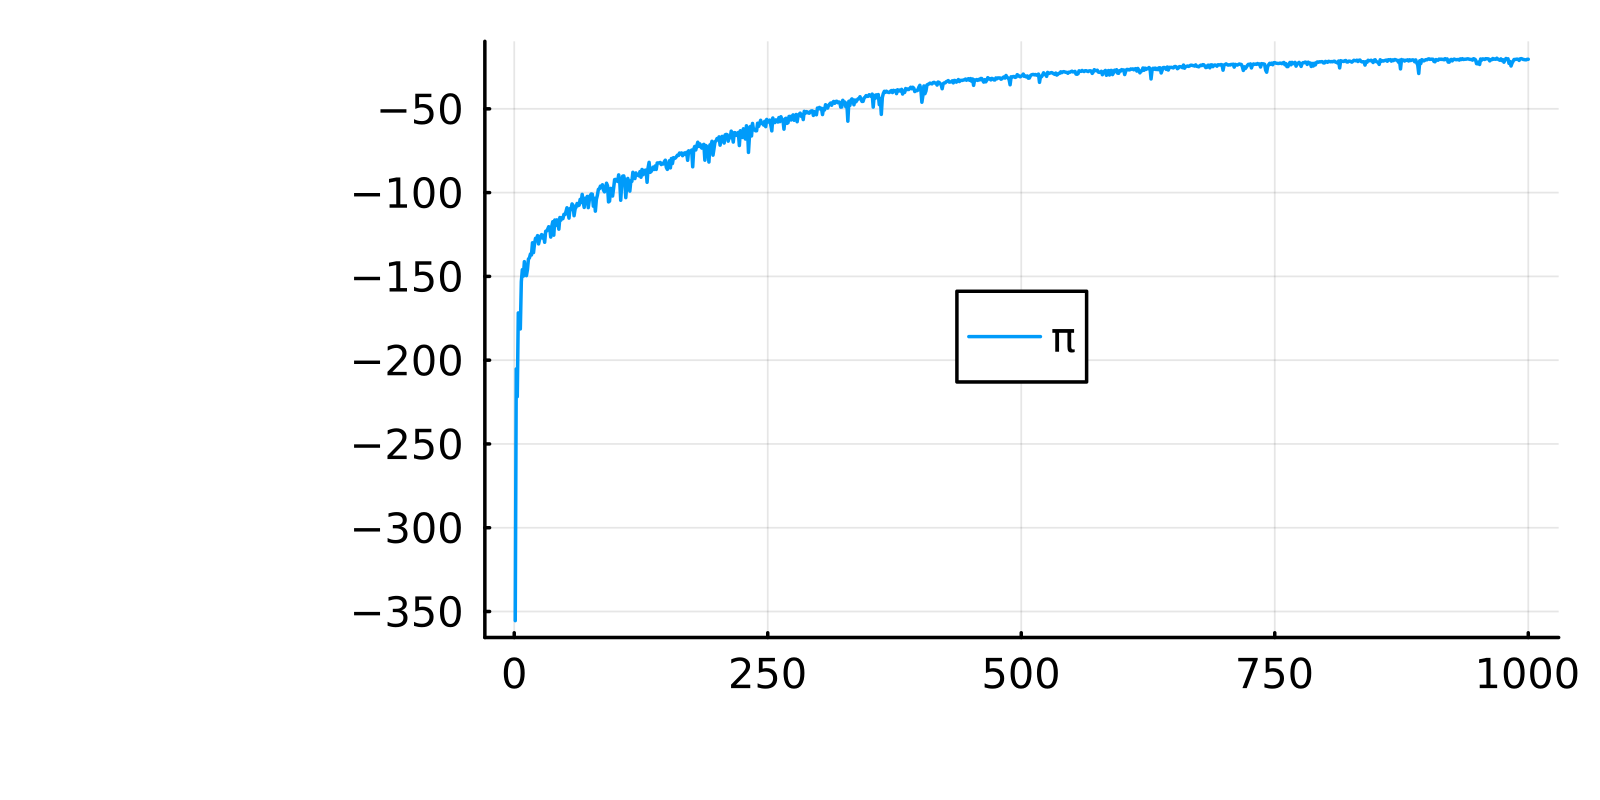

In [14]:
elbo_history = variational_inference(args, observations)
plot(elbo_history, labels="π", thickness_scaling=3.5, size=(1600, 800), legend=:inside)

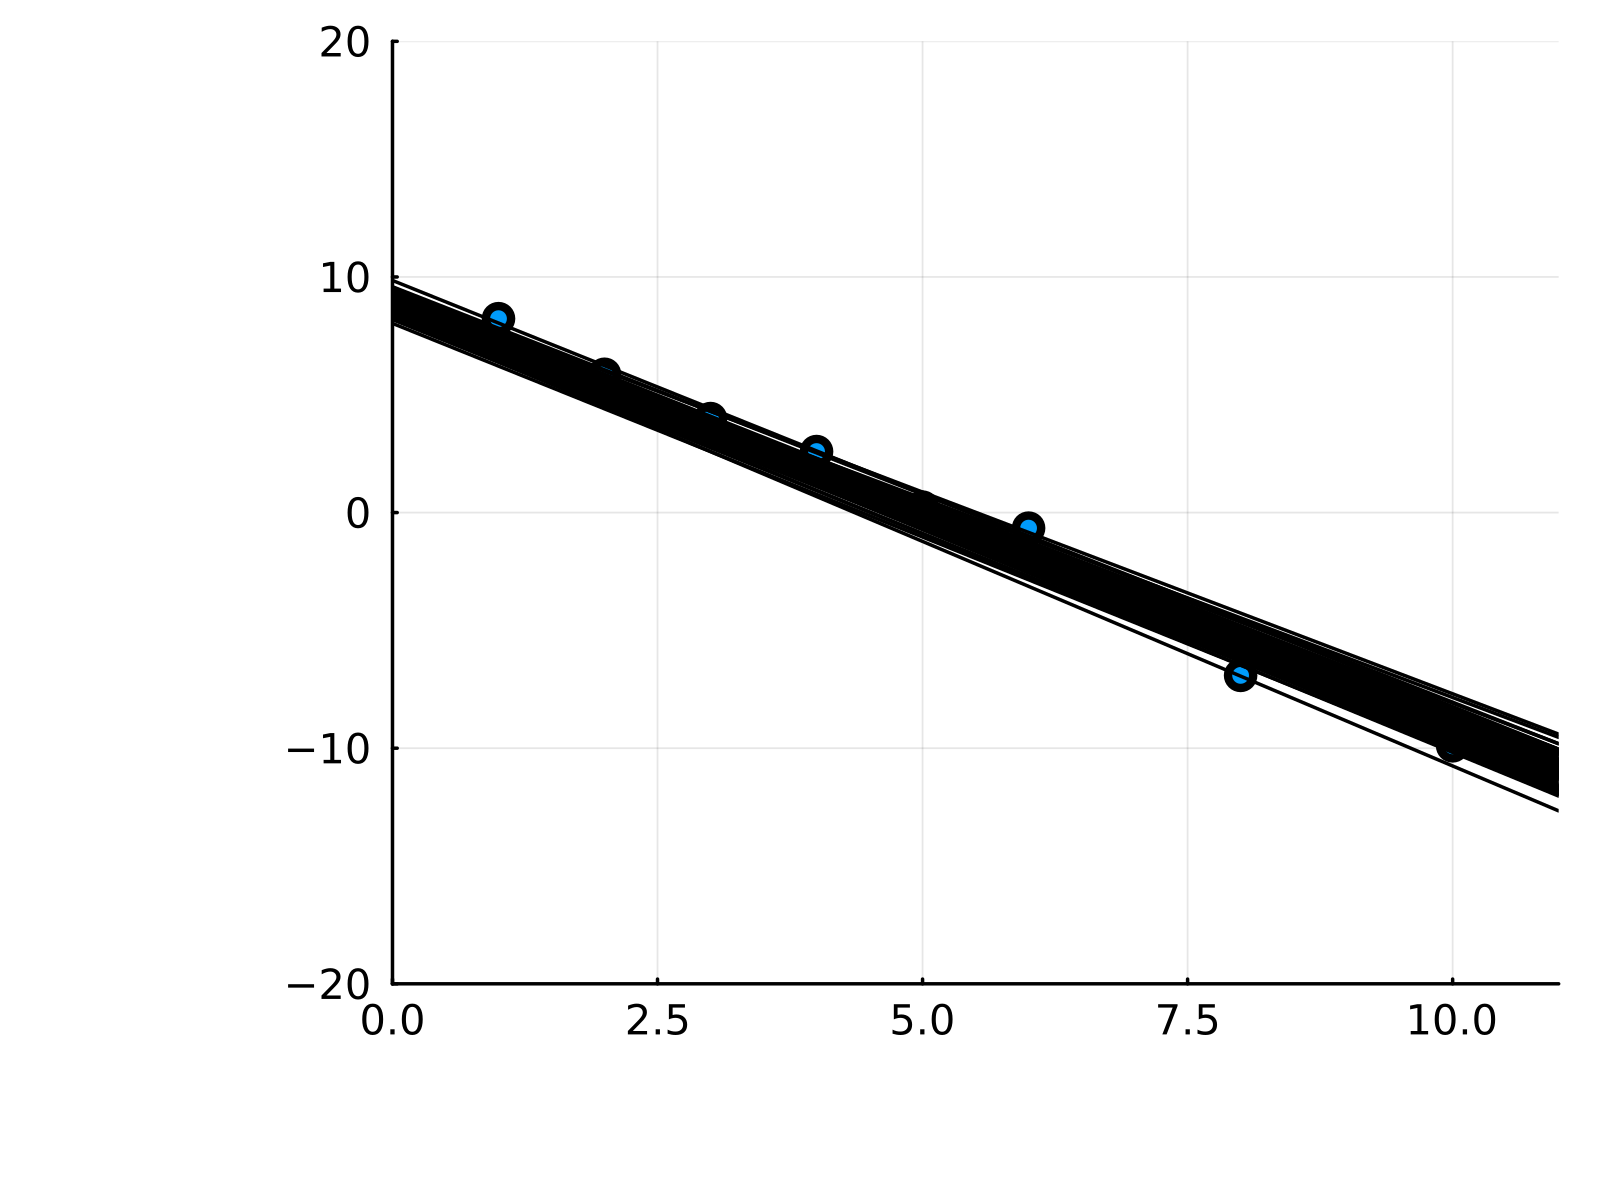

In [15]:
traces = []
for i=1:100
    tr = Gen.simulate(approx, (args,))
    push!(traces, tr)
end
visualize_trace(traces, args, observations, "BBVI")

###  Simulated data examples

In [18]:
tr = Gen.simulate(model, (args, ))
get_choices(tr)
observations_sim = Gen.choicemap()
[observations_sim[:data=>i] = tr[:data=>i] for i in 1:length(args)]
sim_data = []
[push!(sim_data, observations_sim[:data=>i]) for i in 1:length(args)]
elbo_history = variational_inference(args, observations_sim)

iter 1; est objective: -6227.0570434437805
iter 2; est objective: -3799.5850824735508
iter 3; est objective: -1321.3423555258837
iter 4; est objective: -86.4378331302799
iter 5; est objective: -39.795147997486175
iter 6; est objective: -35.377673769293345
iter 7; est objective: -29.90446043943447
iter 8; est objective: -33.27806722206834
iter 9; est objective: -30.827717162522923
iter 10; est objective: -29.950667865698488
iter 11; est objective: -28.370005659966292
iter 12; est objective: -27.155321350646837
iter 13; est objective: -27.781743249579293
iter 14; est objective: -27.016005566559745
iter 15; est objective: -26.829853818538062
iter 16; est objective: -29.03855981808994
iter 17; est objective: -28.72770129489487
iter 18; est objective: -27.808925148367035
iter 19; est objective: -28.206878772817916
iter 20; est objective: -26.991209455899
iter 21; est objective: -29.17363212813469
iter 22; est objective: -29.301685916560235
iter 23; est objective: -25.872401426255
iter 24; e

1000-element Vector{Float64}:
 -6227.0570434437805
 -3799.5850824735508
 -1321.3423555258837
   -86.4378331302799
   -39.795147997486175
   -35.377673769293345
   -29.90446043943447
   -33.27806722206834
   -30.827717162522923
   -29.950667865698488
   -28.370005659966292
   -27.155321350646837
   -27.781743249579293
     ⋮
   -21.17497507934275
   -22.115126974322035
   -21.195707000671682
   -21.318758118670903
   -21.200796536855417
   -21.69249127463527
   -22.045409643562593
   -21.65268769527625
   -21.92474236325625
   -21.222191896120627
   -21.341874586065202
   -21.57307127515039

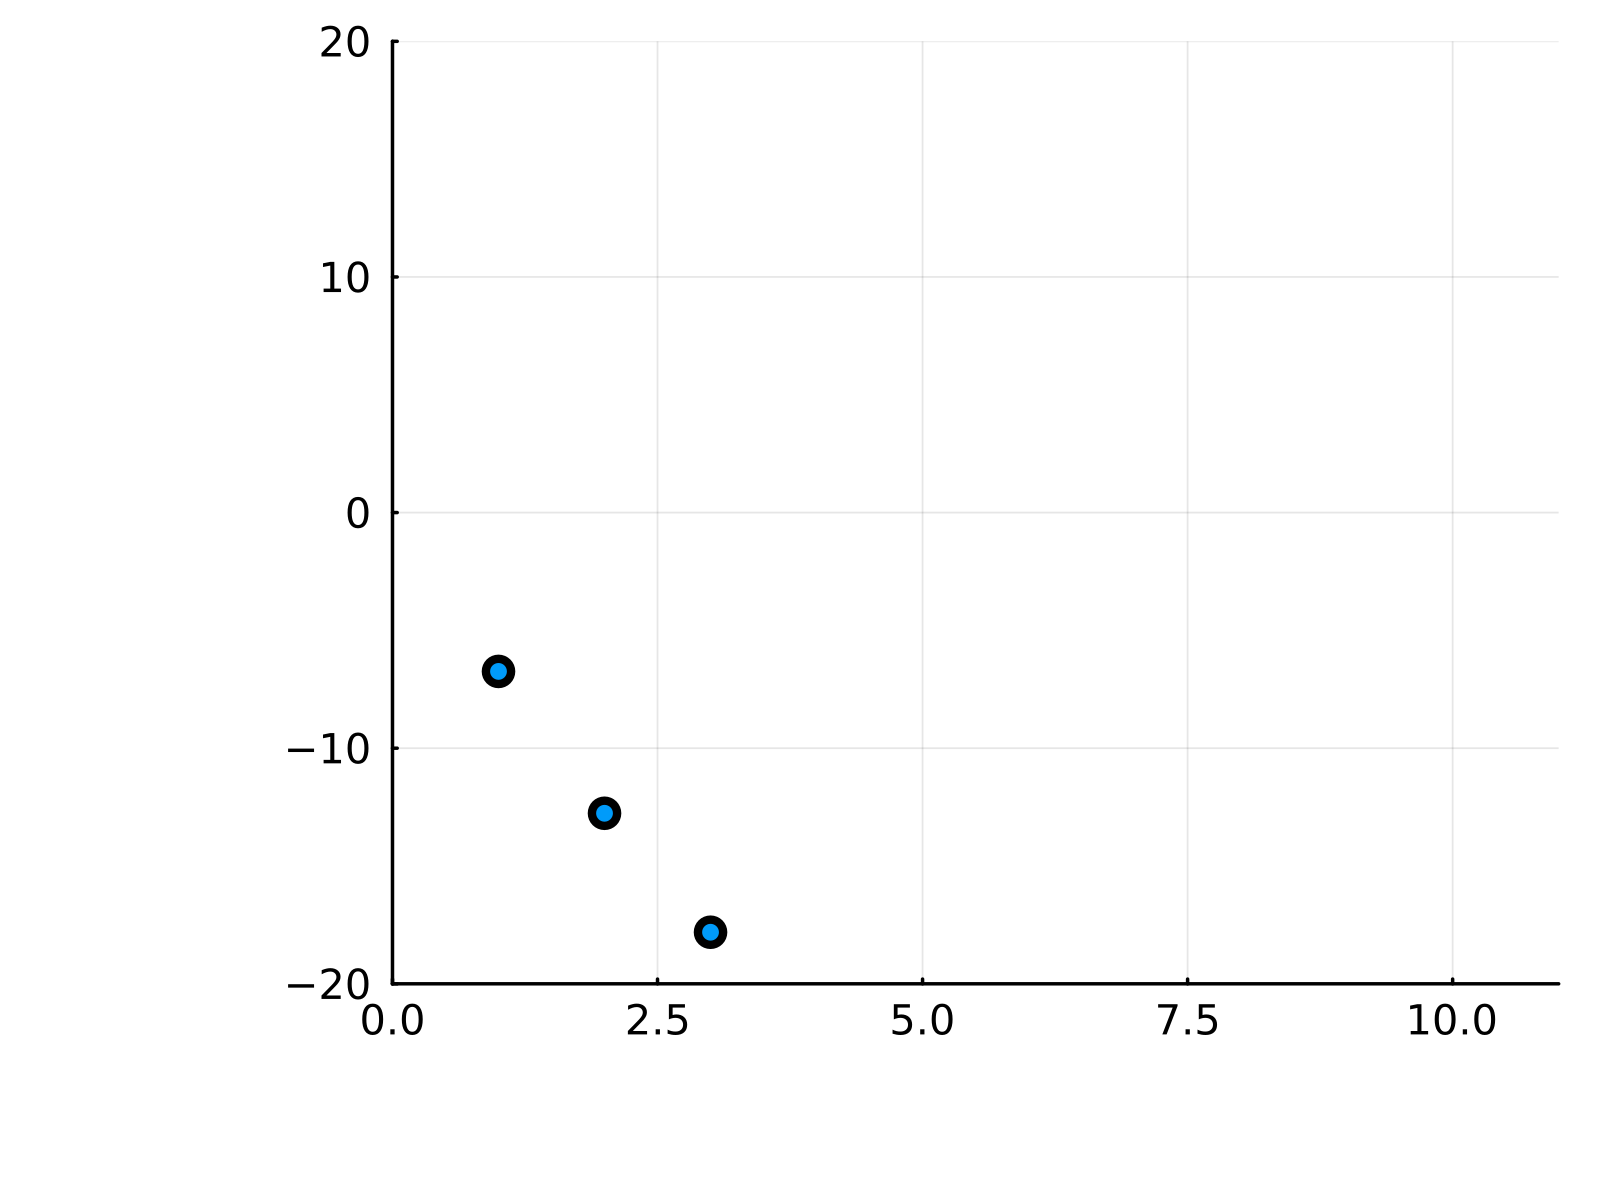

In [19]:
scatter(args, sim_data, xlims=[0, 11], ylims=[-20, 20], label=nothing, thickness_scaling=3.5, size=(1600, 1200))

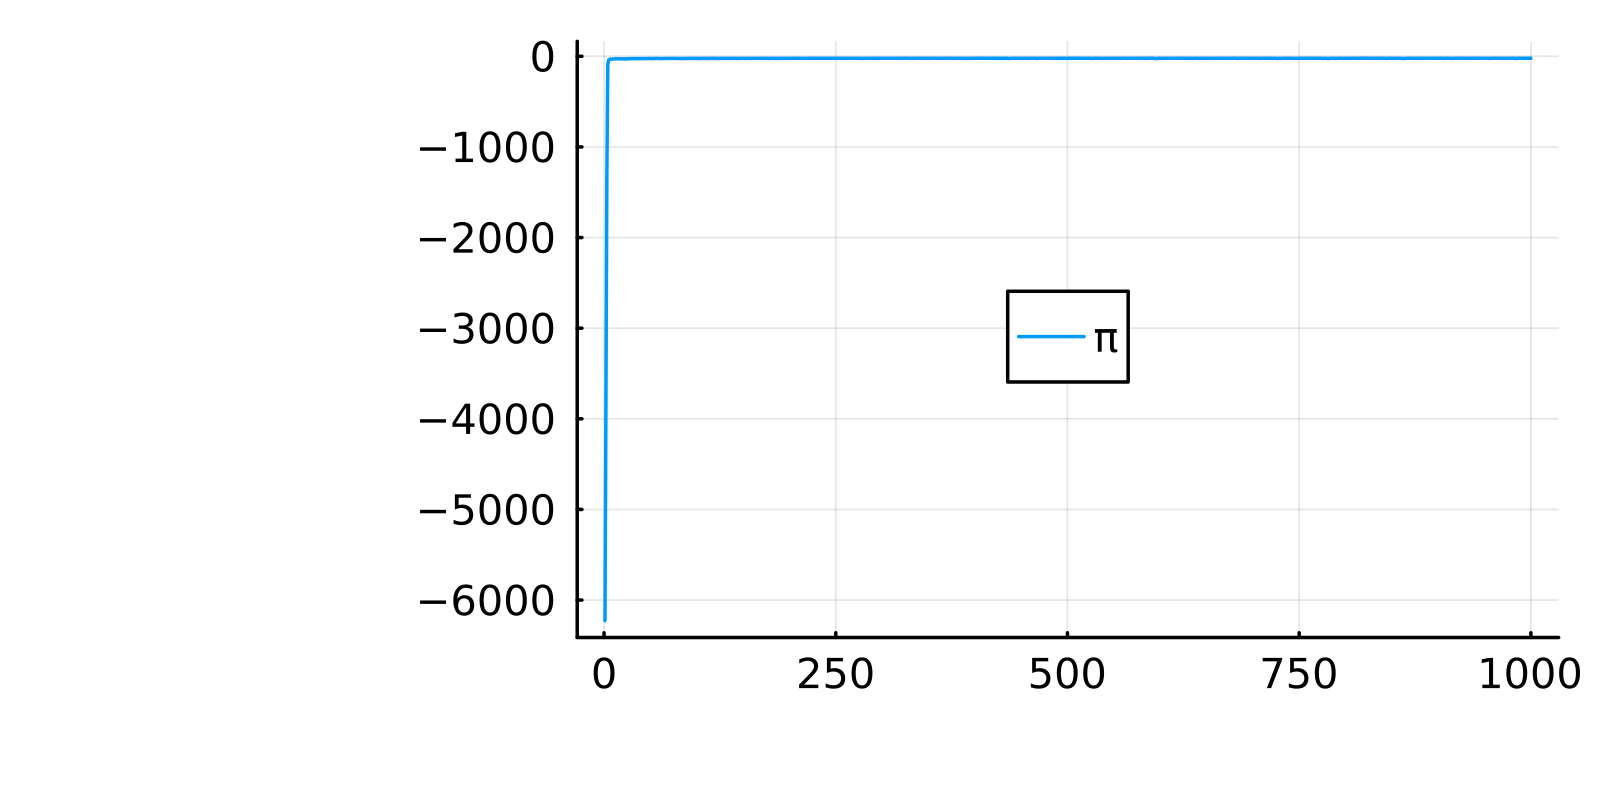

In [20]:
plot(elbo_history, labels="π", thickness_scaling=3.5, size=(1600, 800), legend=:inside)

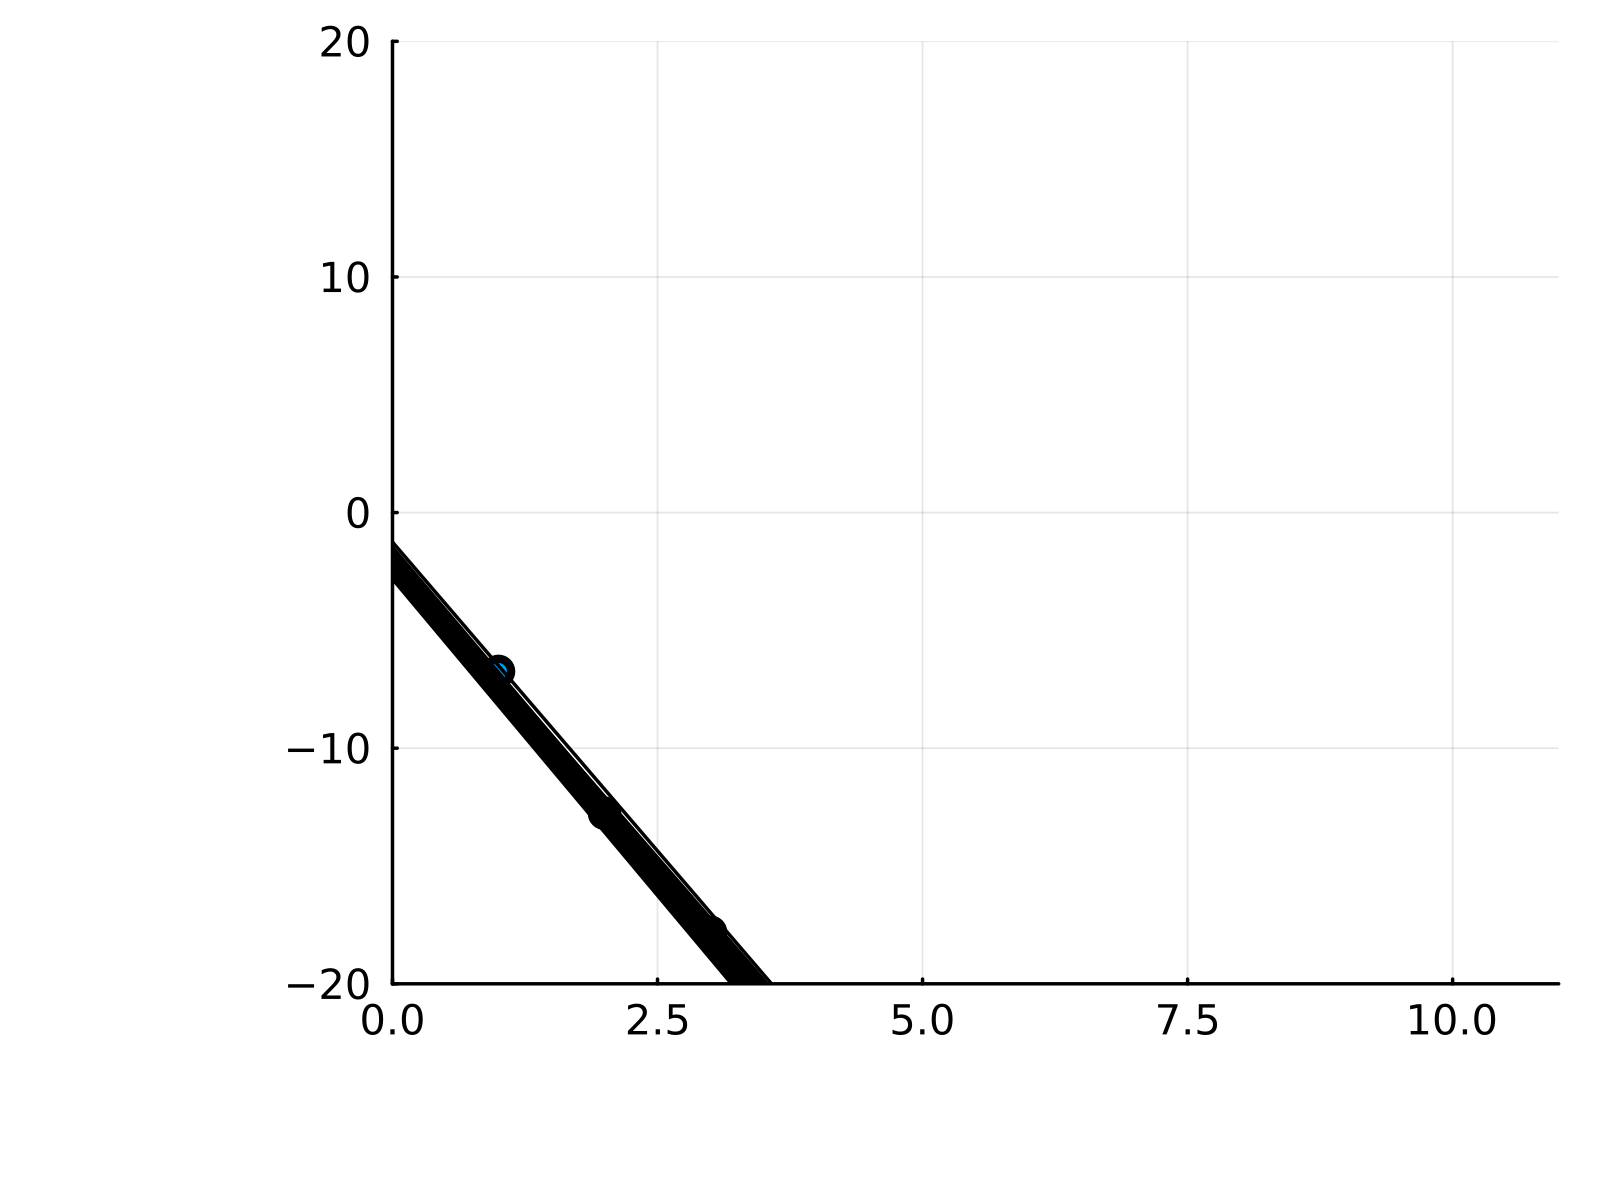

In [22]:
traces = []
for i=1:100
    tr = Gen.simulate(approx, (args,))
    push!(traces, tr)
end
visualize_trace(traces, args, observations_sim, "BBVI")